El sector de Marketing requiere de un análisis exhaustivo sobre sus campañas lanzadas, cuentan con un dato que denominan “conversión” y tiene que ver con que si un cliente, hizo un consumo, en base a la campaña que se le hizo llegar. Ese dato nos dice el grado de efectividad de las campañas. El requisito es la creación de un modelo predictivo que logre predecir la efectividad de una campaña en base a sus características.

Se provee de un csv con los siguientes campos:
* Costo1 y Costo2: son índices de costo de puesta en marcha de la campaña.
* Tópico: Tiene que ver con la temática en la que está basada la campaña.
* Quincena: Es la quincena en el año, se toman 2 por mes.
* TipoProducto: Son las categorías de los productos.
* Conversión: Si el cliente compró o no el producto.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set()

In [2]:
from IPython.display import clear_output

In [3]:
df_conversiones = pd.read_csv("conversiones.csv", sep=",")

In [4]:
df_conversiones.head()

,Costo1,Costo2,Topico,Quincena,TipoProducto,Conversion
0,0.341,0.299,2,7,1,Si
1,0.151,0.079,2,8,1,Si
2,0.384,0.324,4,9,1,Si
3,0.200,0.192,4,9,1,Si
4,0.415,0.020,2,8,1,Si


### Conversion variables categoricas


In [5]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()

df_conversiones['Conversion2'] = le.fit_transform(df_conversiones['Conversion'])

df_conversiones

,Costo1,Costo2,Topico,Quincena,TipoProducto,Conversion,Conversion2
0,0.341,0.299,2,7,1,Si,1
1,0.151,0.079,2,8,1,Si,1
2,0.384,0.324,4,9,1,Si,1
3,0.200,0.192,4,9,1,Si,1
4,0.415,0.020,2,8,1,Si,1
...,...,...,...,...,...,...,...
319941,0.148,0.906,1,10,6,No,0
319942,0.238,0.872,3,16,3,No,0
319943,0.026,0.376,2,9,5,No,0
319944,0.617,0.232,4,4,6,No,0


In [6]:
df = df_conversiones.drop(['Conversion'], axis=1)

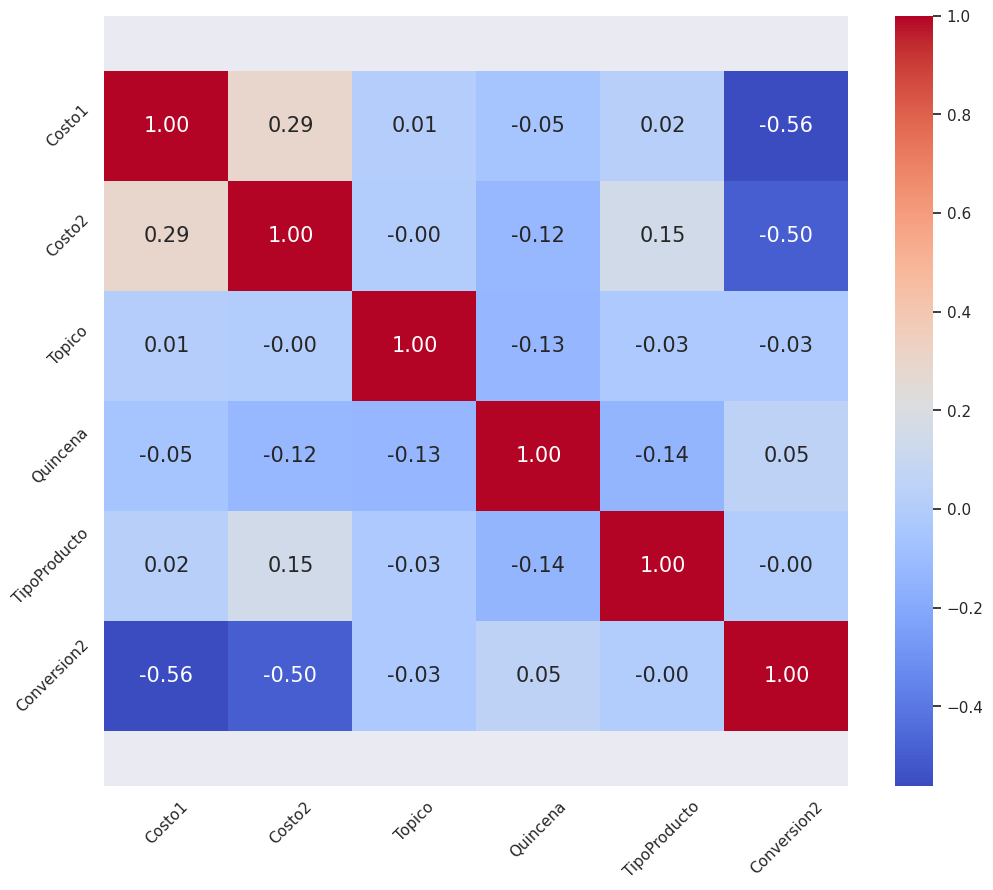

In [7]:
def plot_corre_heatmap(corr):
    '''
    Definimos una función para ayudarnos a graficar un heatmap de correlación
    '''
    plt.figure(figsize=(12,10))
    
    sns.heatmap(corr, 
                cbar = True,  
                square = False, 
                annot=True, 
                fmt= '.2f',
                annot_kws={'size': 15},
                cmap= 'coolwarm')
    
    plt.xticks(rotation = 45)
    plt.yticks(rotation = 45)
    
    # Arreglamos un pequeño problema de visualización
    
    b, t = plt.ylim() # discover the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    plt.ylim(b, t) # update the ylim(bottom, top) values
    plt.show()
    
corr = df.corr()
plot_corre_heatmap(corr)

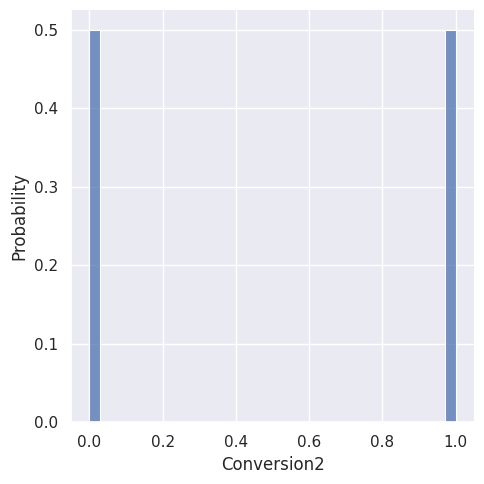

In [8]:
sns.displot(x='Conversion2', data=df, stat='probability') 

### Entrenamiento del modelo

In [12]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_validate


X = df[['Costo1','Costo2','Topico','Quincena','TipoProducto']]
y = df['Conversion2']

In [15]:
clf = DecisionTreeClassifier(max_depth=2)

cross_validate(clf, X, y, cv=5, return_train_score=True, n_jobs = -1)

{'fit_time': array([3.83815169, 4.73508763, 4.0223856 , 4.50999999, 3.84741688]),
 'score_time': array([0.01012921, 0.01461148, 0.01439047, 0.01140523, 0.01332855]),
 'test_score': array([0.87685576, 0.87777587, 0.83053337, 0.8545375 , 0.64790823]),
 'train_score': array([0.83700323, 0.83680462, 0.83445657, 0.82844384, 0.88010095])}

### escoger hiperparametros

In [13]:
tree_train_scores_mean = []
tree_train_scores_std = []
tree_test_scores_mean = []
tree_test_scores_std = []

profundidades = np.arange(1,20,1)

i = 0
i_max = len(profundidades)

for profundidad in profundidades:
    
    i = i + 1
    
    clf = DecisionTreeClassifier(max_depth=profundidad)
    
    tree_scores = cross_validate(clf, X, y, 
                                 cv=5, return_train_score=True, n_jobs=-1)
    
    
    ## acuraccy train 
    tree_train_scores_mean.append(tree_scores['train_score'].mean())
    tree_train_scores_std.append(tree_scores['train_score'].std())
    
    ## acuraccy test
    tree_test_scores_mean.append(tree_scores['test_score'].mean())
    tree_test_scores_std.append(tree_scores['test_score'].std())
    
    clear_output(wait=True)
    print('Completado: ' + str(round(i / i_max * 100, 2)) + '%')

tree_train_scores_mean = np.array(tree_train_scores_mean)
tree_train_scores_std = np.array(tree_train_scores_std)
tree_test_scores_mean = np.array(tree_test_scores_mean)
tree_test_scores_std = np.array(tree_test_scores_std)

Completado: 100.0%


### Grafica de precision

In [23]:
np.sqrt(2)

1.4142135623730951

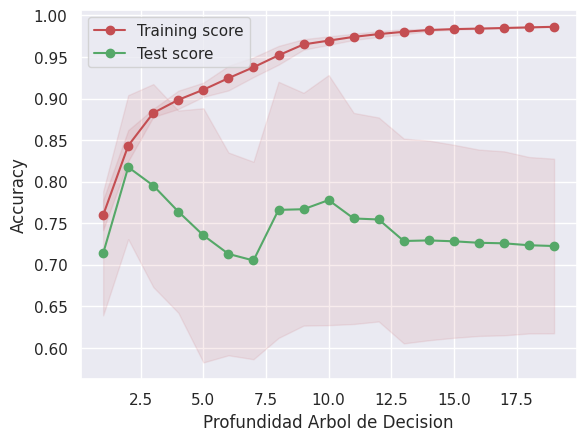

In [35]:

plt.fill_between(profundidades, 
                 tree_train_scores_mean - tree_train_scores_std,
                 tree_train_scores_mean + tree_train_scores_std, alpha=0.1,
                 color="r")


plt.fill_between(profundidades, 
                 tree_test_scores_mean - tree_test_scores_std,
                 tree_test_scores_mean + tree_test_scores_std, alpha=0.1, color="r")

## Grafica de train
plt.plot(profundidades, 
         tree_train_scores_mean, 
         'o-', color="r",
         label="Training score",
         )

#grafica de Test
plt.plot(profundidades, 
         tree_test_scores_mean, 
         'o-', color="g",
         label="Test score")

plt.legend()
plt.ylabel('Accuracy')
plt.xlabel('Profundidad Arbol de Decision')
plt.show()

# Knn

In [36]:
knn_train_scores_mean = []
knn_train_scores_std = []
knn_test_scores_mean = []
knn_test_scores_std = []

n_vecinos = np.arange(1,3,1)

i = 0
i_max = len(n_vecinos)

for vecinos in n_vecinos:
    i = i + 1
    clf = KNeighborsClassifier(n_neighbors=vecinos)
    knn_scores = cross_validate(clf, X, y, cv=5, 
                                return_train_score=True, 
                                n_jobs = -1)
    
    
    knn_train_scores_mean.append(knn_scores['train_score'].mean())
    knn_train_scores_std.append(knn_scores['train_score'].std())
    
    
    knn_test_scores_mean.append(knn_scores['test_score'].mean())
    knn_test_scores_std.append(knn_scores['test_score'].std())
    
    clear_output(wait=True)
    print('Completado: ' + str(round(i / i_max * 100, 2)) + '%')

knn_train_scores_mean = np.array(knn_train_scores_mean)
knn_train_scores_std = np.array(knn_train_scores_std)
knn_test_scores_mean = np.array(knn_test_scores_mean)
knn_test_scores_std = np.array(knn_test_scores_std)

Completado: 100.0%


### Grafica resultados

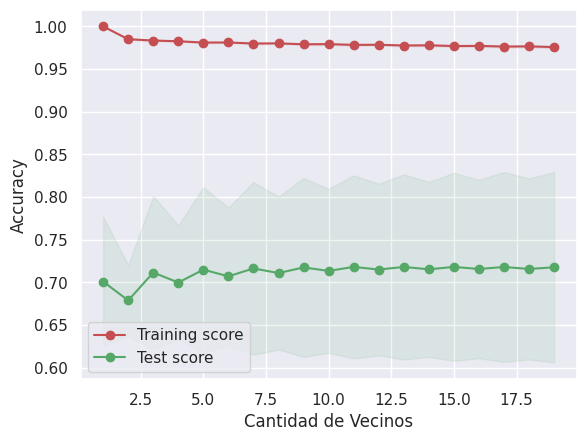

In [37]:
plt.fill_between(n_vecinos, 
                 knn_train_scores_mean - knn_train_scores_std,
                 knn_train_scores_mean + knn_train_scores_std, 
                 alpha=0.1,
                 color="r")

plt.fill_between(n_vecinos, 
                 knn_test_scores_mean - knn_test_scores_std,
                 knn_test_scores_mean + knn_test_scores_std, 
                 alpha=0.1, 
                 color="g")

plt.plot(n_vecinos, knn_train_scores_mean, 'o-', color="r",
         label="Training score")

plt.plot(n_vecinos, knn_test_scores_mean, 'o-', color="g",
         label="Test score")

plt.legend()
plt.ylabel('Accuracy')
plt.xlabel('Cantidad de Vecinos')
plt.show()

## Arbol de decision

In [ ]:
X = df[['Costo1','Costo2','Topico','Quincena','TipoProducto']]

Dado que en la curva de precision la diferencia entre  train score y test score es minima con una profundidad de 2

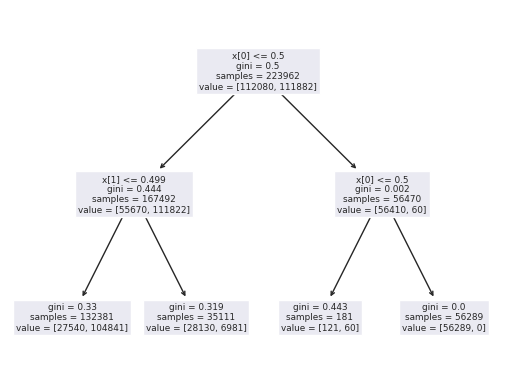

In [39]:
from sklearn import tree
from sklearn.model_selection import train_test_split
import matplotlib.pyplot

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

clf = DecisionTreeClassifier(max_depth = 2)

tree.plot_tree(clf.fit(X_train,y_train))
plt.show()

<BarContainer object of 5 artists>

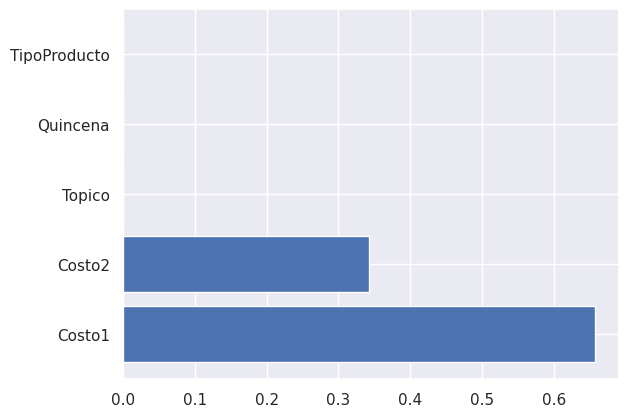

In [40]:
# Visualizar de manera más clara la importancia de las variables:
plt.barh(list(X_train.columns), clf.feature_importances_)

## Knn

In [ ]:
from sklearn import tree
from sklearn.model_selection import train_test_split

import matplotlib.pyplot
from sklearn.metrics import confusion_matrix

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

knn = KNeighborsClassifier(n_neighbors=2)

y_pred = knn.predict(X_test)


conf_matrix = confusion_matrix(y_test, y_pred)

plt.show()